In [0]:
# точка входа в трен USER=yxx USER_FT=xx GPU=0 python3 ..., yxx - y - код таски - рест вс. проганье/редактирование, хх - код юзера от 10 до 19

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import os

In [3]:
from scipy import signal

from scipy.signal import resample
from scipy.signal import butter, lfilter
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.signal import freqz

In [4]:
import mne

In [5]:
annotation_meaning = {
    'S  4': 'baseline_start',
    'S 44': 'baseline_end',
    'S  5': 'rest_start', 
    'S 50': 'rest_end',
    'S  6': 'scroll_start',
    'S 60': 'scroll_end',
    'S  7': 'math_start',
    'S 70': 'math_end',
    'S 66': 'scroll_sample_start', 
    'S 69': 'scroll_sample_end',
    'S 77': 'math_sample_start',
    'S 79': 'math_sample_end'
}

In [6]:
channels_groups = {
    'Fp1': ['Fp1','FP2'],
    'FP2': ['Fp1','FP2'],
    'F7': ['F7','F3','FC5'],
    'F3': ['F7','F3','FC5'],
    'FC5': ['F7','F3','FC5'], 
    'Fz': ['Fz','FC1','FC2'],
    'FC1': ['Fz','FC1','FC2'],
    'FC2': ['Fz','FC1','FC2'], 
    'F4': ['F4','F8','FC6'],
    'F8': ['F4','F8','FC6'],
    'FC6': ['F4','F8','FC6'],
    'T7': ['T7','CP5','P7'],
    'CP5': ['T7','CP5','P7'],
    'P7': ['T7','CP5','P7'], 
    'T8': ['T8','CP6','P8'],
    'CP6': ['T8','CP6','P8'],
    'P8': ['T8','CP6','P8'], 
    'C3': ['C3','Cz','C4'],
    'Cz': ['C3','Cz','C4'],
    'C4': ['C3','Cz','C4'], 
    'P3': ['P3','Pz','P4','CP1','CP2'],
    'Pz': ['P3','Pz','P4','CP1','CP2'],
    'P4': ['P3','Pz','P4','CP1','CP2'],
    'CP1': ['P3','Pz','P4','CP1','CP2'],
    'CP2': ['P3','Pz','P4','CP1','CP2'], 
    'O1': ['O1','Oz','O2'],
    'Oz': ['O1','Oz','O2'],
    'O2': ['O1','Oz','O2']
}

In [7]:
channels = ['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', \
            'P3', 'Pz', 'P4', 'O1', 'O2']


In [8]:
channels_to_interpolate = {
    23: [],
    24: ['O2', 'F7', 'Fz'],
    25: ['Fc2', 'T7', 'C3'],
    26: ['T7', 'Fc2', 'C3'],
    27: ['C3'],
    28: ['Fc2', 'C3', 'T7'],
    29: [],
    30: ['O2', 'T7', 'Fc2', 'C3'],
    31: ['T7', 'Fc2', 'C3'],
    32: ['O2'],
    33: ['O2', 'Oz', 'P8', 'Fc5', 'T7', 'Fc2'],
    34: ['O2'],
    35: ['Fc2', 'C3', 'T7'],
    36: ['T7', 'C3', 'Fc2'],
    37: ['T7'],
    38: ['Fz', 'T7', 'C3', 'Fc2'],
    39: ['O2'],
    40: [],
    41: ['T7', 'C3', 'Fc2'],
    42: ['O2', 'Fz'],
    43: ['T7', 'C3', 'Fc2'],
    44: ['F8', 'Fc2', 'T7', 'C4'],
    45: ['Oz', 'P4', 'P7'],
    46: ['Fc2', 'Fc1', 'O2', 'T7'],
    47: ['O2', 'F7', 'Fz'],
    48: ['F7', 'Fz', 'Fc1'],
    49: ['O2', 'F7', 'Fz'],
    50: ['F7', 'Fz'],
    51: ['T8'],
    52: ['Fp1', 'Fc2']
}

In [9]:
channels_to_interpolate = {k: [j for j in v if j in channels] for k, v in channels_to_interpolate.items()}

In [10]:
channels_groups = {k: [j for j in v if j in channels] for k, v in channels_groups.items() if k in channels}

In [11]:
# channels = ['Fp1','FP2', 'F7','F3','FC5', 'Fz','FC1','FC2', 'F4','F8','FC6', \
#             'T7','CP5','P7', 'T8','CP6','P8', 'C3','Cz','C4', 'P3','Pz','P4','CP1','CP2', 'O1','Oz','O2']


In [12]:
users = range(23, 53)

In [13]:
# for i in all_data_files:
#     for j in i:
#         os.system('cp {} /home/data/HSE_math_exp_2/processing_internal/processing_all_users_merged.limited_cn.our_data/'.format(j))

In [14]:
# os.system('cp -r /home/data/HSE_math_exp_2/processing_internal/processing_all_users_merged.limited_cn.our_data/ /home/data/HSE_math_exp_2/processing_internal/processing_all_users_merged.limited_cn.our_data.demo/')

# DEMO

In [110]:
!ls /home/data/HSE_VALIDATION/1/raw/8

230630_0150_EEG.mdfx  demo  maths  SBCI0037E0000163.EEG  stroop


In [115]:
!ls /home/data/HSE_VALIDATION/1/raw/11/demo

115		     debug_E046_20230703171532_null.zip
230703_0155_EEG.csv  debug_R_E046_20230703171532_null.csv


In [116]:
paths = [
    '/home/data/HSE_VALIDATION/1/raw/1/demo/230609_0142_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/2/demo/230614_0143_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/3/demo/230615_0145_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/4/demo/230615_0146_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/5/demo/230616_0146_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/6/demo/230620_0147_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/8/demo/230630_0150_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/9/demo/230701_0152_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/10/demo/230703_0153_EEG.csv',
    '/home/data/HSE_VALIDATION/1/raw/11/demo/230703_0155_EEG.csv',
]

# REST VS READ

In [117]:
signal_data_inner = []

In [118]:
evt

,eeg_sample,photo_event_order,description
0,7085,2,closed_eyes
1,37594,6,rest1
2,68203,10,read
3,143751,12,rest2
4,174318,16,edit
5,249870,18,rest3
6,280375,22,programming
7,505930,26,rest4


In [119]:
for count, path in enumerate(paths):
    count = count+1
    ch_names = ['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'VEOG', 'C3', 'Cz', 'C4', \
                'HEOG', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'A1', 'A2', \
                'ECG_l', 'ECG_r']

    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eeg', 'eeg', 'eeg', \
               'eog', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg', 'ecg', ]

    evt = pd.read_csv('/home/data/HSE_VALIDATION/1/processed/{}/demo_{}_events.csv'.format(count, count))
#     annot = mne.annotations_from_events(evt.values[:, :3], sfreq=256)
#     annot.to_data_frame()['description'][0]

#     event_id = {
#         '4':'S  4',
#         '44':'S 40',
#         '1':'S  5',
#         '10':'S 50',
#         '3':'S  7',
#         '30':'S 70',
#         '2':'S  6',
#         '20':'S 60',
#         '22':'S 63',
#         '33':'S 73',
#         '29':'S 69',
#         '39':'S 79'
#     }

#     annot.rename(event_id)


    # Load data
    _data_raw = pd.read_csv(path, sep=';', index_col=False)
    _data_raw = _data_raw.drop(columns=['REF'])
    sfreq = 256 
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
    data_raw = mne.io.RawArray(_data_raw.values[:, :-4].T, info)
    #data_raw = mne.io.read_raw(os.path.join(init_dir_path, edf_fname), preload=True)
    samp_rate = data_raw.info['sfreq']
    # data_raw.set_annotations(annot)
    data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
    # data_raw.resample(500)
    data_test = data_raw

    user = count + 9

    data_test = data_test.filter(0.9, 40)
    # annotations = mne.events_from_annotations(data_test)
    # remap = {v: k for k, v in annotations[1].items()}
    # annotations_remaped = []
    # for i in annotations[0]:
    #     annotations_remaped.append((i[0], i[1], remap.get(i[2])))

    # annotations_remaped = [i for i in annotations_remaped if i[2] in ['S  7', 'S 70', 'S  6', 'S 60', 'S  5', 'S 50']]
    data_eeg = data_test.to_data_frame()[channels]
    ch_names = data_eeg.columns
    # for ch_name in ch_names:
    #     if ch_name in channels_to_interpolate[user]:
    #         print(ch_name)
    #         ch_for_interpol = [i for i in channels_groups[ch_name] if i not in channels_to_interpolate[user]]

    #         if len(ch_for_interpol) == 0:
    #             print('W')
    #             ch_for_interpol = [i for i in channels_groups if i not in channels_to_interpolate[user]]

    #         chs_vals = data_eeg[ch_for_interpol].values.mean(-1)

    #         data_eeg[ch_name] = chs_vals

    data_sliced = []
    for i, row in evt.iterrows():
        
        if row['description'] in ['rest1']:
            start = int(evt.loc[i]['eeg_sample'])
            end = int(evt.loc[i+1]['eeg_sample'])
            label = 0
            dur = (end - start) / 1000
            data_sliced.append((start, end, label, dur))

        if row['description'] in ['read']:
            start = int(evt.loc[i]['eeg_sample'])
            end = int(evt.loc[i+1]['eeg_sample'])
            label = 1
            dur = (end - start) / 1000
            data_sliced.append((start, end, label, dur))

        # if row['description'] in ['edit', 'programming']:
        #     start = int(evt.loc[i-1]['eeg_sample'] / 256 * 500)
        #     end = int(row['eeg_sample'] / 256 * 500)
        #     label = 2
        #     dur = (end - start) / 1000
        #     data_sliced.append((start, end, label, dur))

    data_sliced_window = []
    for s in data_sliced:
        if s[2] == 0:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # if counter > 50:
                #     break

        else:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # for i in range(3000, int(s[3] * 1000), 1000):
    #                 i = 1500 # fix to only one fragment from each sample
    #                 data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))


    for j, (start, end, label, dur) in enumerate(data_sliced_window):
        signal_data_inner.append({
            'data': data_eeg.iloc[start:end].values,
            'label': label,
            'data_names': data_eeg.columns,
            'user': user,
            'seq_id': j
        })

/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=575577
    Range : 0 ... 575576 =      0.000 ...  2248.344 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=541376
    Range : 0 ... 541375 =      0.000 ...  2114.746 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=291394
    Range : 0 ... 291393 =      0.000 ...  1138.254 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=547893
    Range : 0 ... 547892 =      0.000 ...  2140.203 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=534225
    Range : 0 ... 534224 =      0.000 ...  2086.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543117
    Range : 0 ... 543116 =      0.000 ...  2121.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=554086
    Range : 0 ... 554085 =      0.000 ...  2164.395 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=539987
    Range : 0 ... 539986 =      0.000 ...  2109.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=537101
    Range : 0 ... 537100 =      0.000 ...  2098.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/1197857168.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543572
    Range : 0 ... 543571 =      0.000 ...  2123.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/1197857168.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


In [120]:
len(data_sliced_window)

70

In [121]:
data_sliced_window[0]

(36839, 38339, 0, 1.5)

In [122]:
signal_data_inner[-1]

{'data': array([[ -5621445.29105262,  -8936352.13666539,    680615.40693498, ...,
           6735132.85564275,   7561510.31455079,   8017926.57715208],
        [ -7960239.68836062, -10865782.92730474,   -846256.30142818, ...,
           4367632.17794305,   4246514.379301  ,   5630703.05349174],
        [ -8896932.65009555, -13053298.21842633,  -2022797.77672675, ...,
           2477285.71009338,    633056.68655931,   2795758.90997978],
        ...,
        [  9904042.75497126,   1895008.26321243,  14249540.60914131, ...,
            650870.14293668,  10493872.71217146,   3824354.87927164],
        [ 11861883.03579619,   5532862.02474541,  14967048.91933637, ...,
           4209701.81538768,  15564911.58747487,   7291236.09802136],
        [ 11646386.87018746,   7060056.01218191,  14544010.51486409, ...,
           5809747.12946974,  12990424.22396639,   5989303.00241039]]),
 'label': 1,
 'data_names': Index(['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', 'P3',
        'P

In [37]:
!ls /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/ | grep x_302

In [123]:
SHIFT=300

In [124]:
for sample in signal_data_inner:
    user_id = sample['user']
    path_file = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_{}_{}.npy'.format(user_id + SHIFT, sample['seq_id'])
    
    np.save(path_file, sample['data'])

In [125]:
path_file

'/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_319_69.npy'

In [126]:
len(signal_data_inner[0]['data_names'])

15

In [127]:
ys = {}

for sample in signal_data_inner:
    if ys.get(sample['user']) is None:
        ys[sample['user']] = []
        
    ys[sample['user']].append(sample['label'])

In [128]:
for user_id in ys:
    path = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/{}_y.npy'.format(user_id + SHIFT)
    np.save(path, ys[user_id])


In [129]:
ys.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

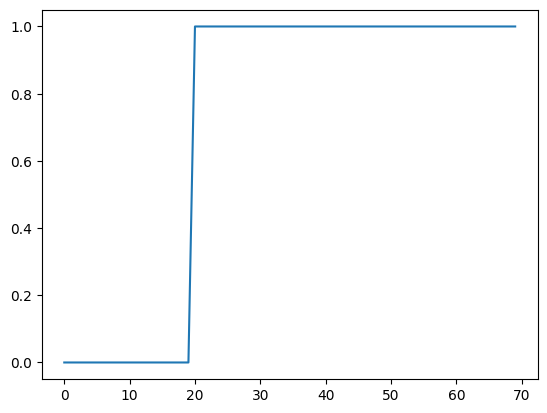

In [130]:
plt.plot(ys[15])

# READ VS PROGRAMMING

In [131]:
signal_data_inner = []

In [132]:
for count, path in enumerate(paths):
    count = count+1
    ch_names = ['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'VEOG', 'C3', 'Cz', 'C4', \
                'HEOG', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'A1', 'A2', \
                'ECG_l', 'ECG_r']

    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eeg', 'eeg', 'eeg', \
               'eog', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg', 'ecg', ]

    evt = pd.read_csv('/home/data/HSE_VALIDATION/1/processed/{}/demo_{}_events.csv'.format(count, count))
#     annot = mne.annotations_from_events(evt.values[:, :3], sfreq=256)
#     annot.to_data_frame()['description'][0]

#     event_id = {
#         '4':'S  4',
#         '44':'S 40',
#         '1':'S  5',
#         '10':'S 50',
#         '3':'S  7',
#         '30':'S 70',
#         '2':'S  6',
#         '20':'S 60',
#         '22':'S 63',
#         '33':'S 73',
#         '29':'S 69',
#         '39':'S 79'
#     }

#     annot.rename(event_id)


    # Load data
    _data_raw = pd.read_csv(path, sep=';', index_col=False)
    _data_raw = _data_raw.drop(columns=['REF'])
    sfreq = 256 
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
    data_raw = mne.io.RawArray(_data_raw.values[:, :-4].T, info)
    #data_raw = mne.io.read_raw(os.path.join(init_dir_path, edf_fname), preload=True)
    samp_rate = data_raw.info['sfreq']
    # data_raw.set_annotations(annot)
    data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
    # data_raw.resample(500)
    data_test = data_raw

    user = count + 9

    data_test = data_test.filter(0.9, 40)
    # annotations = mne.events_from_annotations(data_test)
    # remap = {v: k for k, v in annotations[1].items()}
    # annotations_remaped = []
    # for i in annotations[0]:
    #     annotations_remaped.append((i[0], i[1], remap.get(i[2])))

    # annotations_remaped = [i for i in annotations_remaped if i[2] in ['S  7', 'S 70', 'S  6', 'S 60', 'S  5', 'S 50']]
    data_eeg = data_test.to_data_frame()[channels]
    ch_names = data_eeg.columns
    # for ch_name in ch_names:
    #     if ch_name in channels_to_interpolate[user]:
    #         print(ch_name)
    #         ch_for_interpol = [i for i in channels_groups[ch_name] if i not in channels_to_interpolate[user]]

    #         if len(ch_for_interpol) == 0:
    #             print('W')
    #             ch_for_interpol = [i for i in channels_groups if i not in channels_to_interpolate[user]]

    #         chs_vals = data_eeg[ch_for_interpol].values.mean(-1)

    #         data_eeg[ch_name] = chs_vals

    data_sliced = []
    for i, row in evt.iterrows():
        
        if row['description'] in ['read']:
            start = int(evt.loc[i]['eeg_sample'])
            end = int(evt.loc[i+1]['eeg_sample'])
            label = 0
            dur = (end - start) / 1000
            data_sliced.append((start, end, label, dur))

        if row['description'] in ['programming']:
            start = int(evt.loc[i]['eeg_sample'])
            end = int(evt.loc[i+1]['eeg_sample'])
            label = 1
            dur = (end - start) / 1000
            data_sliced.append((start, end, label, dur))

        # if row['description'] in ['edit', 'programming']:
        #     start = int(evt.loc[i-1]['eeg_sample'] / 256 * 500)
        #     end = int(row['eeg_sample'] / 256 * 500)
        #     label = 2
        #     dur = (end - start) / 1000
        #     data_sliced.append((start, end, label, dur))

    data_sliced_window = []
    for s in data_sliced:
        if s[2] == 0:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # if counter > 50:
                #     break

        else:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # for i in range(3000, int(s[3] * 1000), 1000):
    #                 i = 1500 # fix to only one fragment from each sample
    #                 data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))


    for j, (start, end, label, dur) in enumerate(data_sliced_window):
        if len(data_eeg.iloc[start:end].values) != 0:
            signal_data_inner.append({
                'data': data_eeg.iloc[start:end].values,
                'label': label,
                'data_names': data_eeg.columns,
                'user': user,
                'seq_id': j
            })

/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=575577
    Range : 0 ... 575576 =      0.000 ...  2248.344 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=541376
    Range : 0 ... 541375 =      0.000 ...  2114.746 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=291394
    Range : 0 ... 291393 =      0.000 ...  1138.254 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=547893
    Range : 0 ... 547892 =      0.000 ...  2140.203 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=534225
    Range : 0 ... 534224 =      0.000 ...  2086.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543117
    Range : 0 ... 543116 =      0.000 ...  2121.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=554086
    Range : 0 ... 554085 =      0.000 ...  2164.395 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=539987
    Range : 0 ... 539986 =      0.000 ...  2109.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=537101
    Range : 0 ... 537100 =      0.000 ...  2098.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3215150714.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543572
    Range : 0 ... 543571 =      0.000 ...  2123.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3215150714.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished


In [133]:
data_sliced

[(67444, 143004, 0, 75.56), (279611, 505183, 1, 225.572)]

In [136]:
signal_data_inner[-1]

{'data': array([[ 12713486.13681455,  18832845.42237824,  -6318859.35129568, ...,
          15194737.14086231,  14479310.42575525,  13675665.5391466 ],
        [ 14624313.52884486,  21342122.75663049,  -6765902.23702666, ...,
          12420665.78774899,  16435579.166069  ,  13635405.90804944],
        [ 14585260.57118903,  22302281.11149466,  -8355102.98133168, ...,
           7548424.08048597,  12749013.98560082,   8868132.86203715],
        ...,
        [  7875882.17461386,   6027776.2064833 ,  19648881.65683606, ...,
         -14651436.45046798,   1441628.39893048,  -8567175.21406037],
        [ 15818915.57124829,  15776415.95329905,  19724031.42431048, ...,
         -12979450.71137024,   1532356.64667443,  -6866656.47002036],
        [ 21085868.14009129,  23441622.43131518,  17332566.4062147 , ...,
         -12569060.12433708,  -6448796.02218211, -10291089.29287238]]),
 'label': 1,
 'data_names': Index(['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', 'P3',
        'P

In [135]:
len(data_sliced_window)

200

In [66]:
# !rm /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/317_y*

In [67]:
# !ls /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/ | grep x_302

In [137]:
SHIFT=400

In [138]:
for sample in signal_data_inner:
    user_id = sample['user']
    path_file = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_{}_{}.npy'.format(user_id + SHIFT, sample['seq_id'])
    
    np.save(path_file, sample['data'])

In [139]:
path_file

'/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_419_199.npy'

In [140]:
len(signal_data_inner[0]['data_names'])

15

In [141]:
ys = {}

for sample in signal_data_inner:
    if ys.get(sample['user']) is None:
        ys[sample['user']] = []
        
    ys[sample['user']].append(sample['label'])

In [142]:
for user_id in ys:
    path = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/{}_y.npy'.format(user_id + SHIFT)
    np.save(path, ys[user_id])


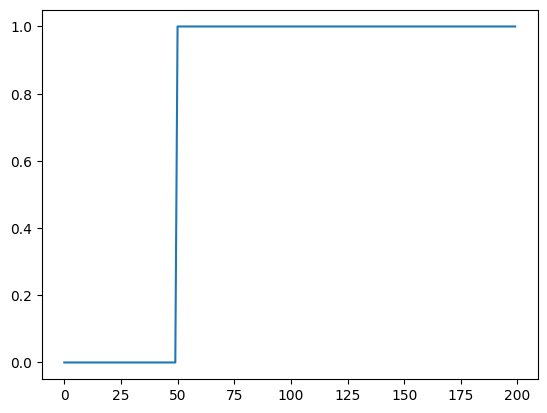

In [143]:
plt.plot(ys[15])

In [103]:
a = np.load('/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/310_y.npy')
b = np.load('/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/410_y.npy')

In [109]:
a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [108]:
b

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# REST VS PROGRAMMING

In [144]:
signal_data_inner = []

In [145]:
for count, path in enumerate(paths):
    count = count+1
    ch_names = ['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'VEOG', 'C3', 'Cz', 'C4', \
                'HEOG', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'A1', 'A2', \
                'ECG_l', 'ECG_r']

    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eeg', 'eeg', 'eeg', \
               'eog', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg', 'ecg', ]

    evt = pd.read_csv('/home/data/HSE_VALIDATION/1/processed/{}/demo_{}_events.csv'.format(count, count))
#     annot = mne.annotations_from_events(evt.values[:, :3], sfreq=256)
#     annot.to_data_frame()['description'][0]

#     event_id = {
#         '4':'S  4',
#         '44':'S 40',
#         '1':'S  5',
#         '10':'S 50',
#         '3':'S  7',
#         '30':'S 70',
#         '2':'S  6',
#         '20':'S 60',
#         '22':'S 63',
#         '33':'S 73',
#         '29':'S 69',
#         '39':'S 79'
#     }

#     annot.rename(event_id)


    # Load data
    _data_raw = pd.read_csv(path, sep=';', index_col=False)
    _data_raw = _data_raw.drop(columns=['REF'])
    sfreq = 256 
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
    data_raw = mne.io.RawArray(_data_raw.values[:, :-4].T, info)
    #data_raw = mne.io.read_raw(os.path.join(init_dir_path, edf_fname), preload=True)
    samp_rate = data_raw.info['sfreq']
    # data_raw.set_annotations(annot)
    data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
    # data_raw.resample(500)
    data_test = data_raw

    user = count + 9

    data_test = data_test.filter(0.9, 40)
    # annotations = mne.events_from_annotations(data_test)
    # remap = {v: k for k, v in annotations[1].items()}
    # annotations_remaped = []
    # for i in annotations[0]:
    #     annotations_remaped.append((i[0], i[1], remap.get(i[2])))

    # annotations_remaped = [i for i in annotations_remaped if i[2] in ['S  7', 'S 70', 'S  6', 'S 60', 'S  5', 'S 50']]
    data_eeg = data_test.to_data_frame()[channels]
    ch_names = data_eeg.columns
    # for ch_name in ch_names:
    #     if ch_name in channels_to_interpolate[user]:
    #         print(ch_name)
    #         ch_for_interpol = [i for i in channels_groups[ch_name] if i not in channels_to_interpolate[user]]

    #         if len(ch_for_interpol) == 0:
    #             print('W')
    #             ch_for_interpol = [i for i in channels_groups if i not in channels_to_interpolate[user]]

    #         chs_vals = data_eeg[ch_for_interpol].values.mean(-1)

    #         data_eeg[ch_name] = chs_vals

    data_sliced = []
    for i, row in evt.iterrows():
        try:
            if row['description'] in ['rest1', 'rest2', 'rest3']:
                start = int(evt.loc[i]['eeg_sample'])
                end = int(evt.loc[i+1]['eeg_sample'])
                label = 0
                dur = (end - start) / 1000
                data_sliced.append((start, end, label, dur))

            if row['description'] in ['programming']:
                start = int(evt.loc[i]['eeg_sample'])
                end = int(evt.loc[i+1]['eeg_sample'])
                label = 1
                dur = (end - start) / 1000
                data_sliced.append((start, end, label, dur))
        except:
            pass
        # if row['description'] in ['edit', 'programming']:
        #     start = int(evt.loc[i-1]['eeg_sample'] / 256 * 500)
        #     end = int(row['eeg_sample'] / 256 * 500)
        #     label = 2
        #     dur = (end - start) / 1000
        #     data_sliced.append((start, end, label, dur))

    data_sliced_window = []
    for s in data_sliced:
        if s[2] == 0:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # if counter > 50:
                #     break

        else:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # for i in range(3000, int(s[3] * 1000), 1000):
    #                 i = 1500 # fix to only one fragment from each sample
    #                 data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))


    for j, (start, end, label, dur) in enumerate(data_sliced_window):
        if len(data_eeg.iloc[start:end].values) != 0:
            signal_data_inner.append({
                'data': data_eeg.iloc[start:end].values,
                'label': label,
                'data_names': data_eeg.columns,
                'user': user,
                'seq_id': j
            })

/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=575577
    Range : 0 ... 575576 =      0.000 ...  2248.344 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=541376
    Range : 0 ... 541375 =      0.000 ...  2114.746 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=291394
    Range : 0 ... 291393 =      0.000 ...  1138.254 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=547893
    Range : 0 ... 547892 =      0.000 ...  2140.203 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=534225
    Range : 0 ... 534224 =      0.000 ...  2086.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543117
    Range : 0 ... 543116 =      0.000 ...  2121.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=554086
    Range : 0 ... 554085 =      0.000 ...  2164.395 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=539987
    Range : 0 ... 539986 =      0.000 ...  2109.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=537101
    Range : 0 ... 537100 =      0.000 ...  2098.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3571970388.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543572
    Range : 0 ... 543571 =      0.000 ...  2123.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3571970388.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished


In [146]:
data_sliced

[(36839, 67444, 0, 30.605),
 (143004, 173563, 0, 30.559),
 (249107, 279611, 0, 30.504),
 (279611, 505183, 1, 225.572)]

In [147]:
signal_data_inner

[{'data': array([[-5.27193894e+07, -2.62984792e+07, -7.06905055e+07, ...,
           2.52379930e+07,  2.52062476e+07,  3.13818422e+07],
         [-5.37467333e+07, -2.69090989e+07, -7.32960368e+07, ...,
           2.34107733e+07,  2.30508455e+07,  2.81268912e+07],
         [-5.51962251e+07, -2.69638988e+07, -7.62423996e+07, ...,
           2.27554052e+07,  2.26971577e+07,  2.58546443e+07],
         ...,
         [-4.75504432e+06,  1.44392007e+06, -1.32390997e+07, ...,
           7.17162373e+06,  4.24253825e+06,  9.13155706e+06],
         [-2.35785543e+06,  3.19491716e+06, -9.92106032e+06, ...,
           1.16195967e+07,  7.75023383e+06,  1.29816740e+07],
         [ 2.02997899e+04,  4.38524996e+06, -6.59307272e+06, ...,
           1.56842599e+07,  1.15387027e+07,  1.44880750e+07]]),
  'label': 0,
  'data_names': Index(['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', 'P3',
         'Pz', 'P4', 'O1', 'O2'],
        dtype='object'),
  'user': 10,
  'seq_id': 0},
 {'data': arra

In [148]:
len(data_sliced_window)

210

In [149]:
# !rm /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/317_y*

In [150]:
!ls /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/ | grep x_302

In [151]:
SHIFT=500

In [152]:
for sample in signal_data_inner:
    user_id = sample['user']
    path_file = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_{}_{}.npy'.format(user_id + SHIFT, sample['seq_id'])
    
    np.save(path_file, sample['data'])

In [153]:
path_file

'/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_519_209.npy'

In [154]:
len(signal_data_inner[0]['data_names'])

15

In [155]:
ys = {}

for sample in signal_data_inner:
    if ys.get(sample['user']) is None:
        ys[sample['user']] = []
        
    ys[sample['user']].append(sample['label'])

In [156]:
for user_id in ys:
    path = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/{}_y.npy'.format(user_id + SHIFT)
    np.save(path, ys[user_id])


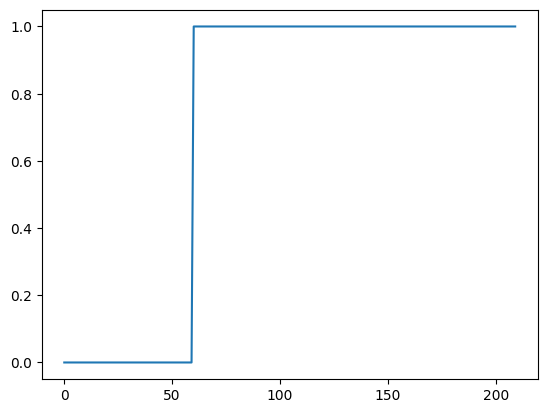

In [157]:
plt.plot(ys[15])

# REST VS EDITING

In [158]:
signal_data_inner = []

In [159]:
for count, path in enumerate(paths):
    count = count+1
    ch_names = ['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'VEOG', 'C3', 'Cz', 'C4', \
                'HEOG', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'A1', 'A2', \
                'ECG_l', 'ECG_r']

    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eeg', 'eeg', 'eeg', \
               'eog', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg', 'ecg', ]

    evt = pd.read_csv('/home/data/HSE_VALIDATION/1/processed/{}/demo_{}_events.csv'.format(count, count))
#     annot = mne.annotations_from_events(evt.values[:, :3], sfreq=256)
#     annot.to_data_frame()['description'][0]

#     event_id = {
#         '4':'S  4',
#         '44':'S 40',
#         '1':'S  5',
#         '10':'S 50',
#         '3':'S  7',
#         '30':'S 70',
#         '2':'S  6',
#         '20':'S 60',
#         '22':'S 63',
#         '33':'S 73',
#         '29':'S 69',
#         '39':'S 79'
#     }

#     annot.rename(event_id)


    # Load data
    _data_raw = pd.read_csv(path, sep=';', index_col=False)
    _data_raw = _data_raw.drop(columns=['REF'])
    sfreq = 256 
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
    data_raw = mne.io.RawArray(_data_raw.values[:, :-4].T, info)
    #data_raw = mne.io.read_raw(os.path.join(init_dir_path, edf_fname), preload=True)
    samp_rate = data_raw.info['sfreq']
    # data_raw.set_annotations(annot)
    data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
    # data_raw.resample(500)
    data_test = data_raw

    user = count + 9

    data_test = data_test.filter(0.9, 40)
    # annotations = mne.events_from_annotations(data_test)
    # remap = {v: k for k, v in annotations[1].items()}
    # annotations_remaped = []
    # for i in annotations[0]:
    #     annotations_remaped.append((i[0], i[1], remap.get(i[2])))

    # annotations_remaped = [i for i in annotations_remaped if i[2] in ['S  7', 'S 70', 'S  6', 'S 60', 'S  5', 'S 50']]
    data_eeg = data_test.to_data_frame()[channels]
    ch_names = data_eeg.columns
    # for ch_name in ch_names:
    #     if ch_name in channels_to_interpolate[user]:
    #         print(ch_name)
    #         ch_for_interpol = [i for i in channels_groups[ch_name] if i not in channels_to_interpolate[user]]

    #         if len(ch_for_interpol) == 0:
    #             print('W')
    #             ch_for_interpol = [i for i in channels_groups if i not in channels_to_interpolate[user]]

    #         chs_vals = data_eeg[ch_for_interpol].values.mean(-1)

    #         data_eeg[ch_name] = chs_vals

    data_sliced = []
    for i, row in evt.iterrows():
        try:
            if row['description'] in ['rest1', 'rest2', 'rest3']:
                start = int(evt.loc[i]['eeg_sample'])
                end = int(evt.loc[i+1]['eeg_sample'])
                label = 0
                dur = (end - start) / 1000
                data_sliced.append((start, end, label, dur))

            if row['description'] in ['edit']:
                start = int(evt.loc[i]['eeg_sample'])
                end = int(evt.loc[i+1]['eeg_sample'])
                label = 1
                dur = (end - start) / 1000
                data_sliced.append((start, end, label, dur))
        except:
            pass
        # if row['description'] in ['edit', 'programming']:
        #     start = int(evt.loc[i-1]['eeg_sample'] / 256 * 500)
        #     end = int(row['eeg_sample'] / 256 * 500)
        #     label = 2
        #     dur = (end - start) / 1000
        #     data_sliced.append((start, end, label, dur))

    data_sliced_window = []
    for s in data_sliced:
        if s[2] == 0:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # if counter > 50:
                #     break

        else:
            counter = 0
            for i in range(1500, int(s[3] * 1000), 1500):
                data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))
                counter += 1
                # for i in range(3000, int(s[3] * 1000), 1000):
    #                 i = 1500 # fix to only one fragment from each sample
    #                 data_sliced_window.append((s[0] + i - 1500, s[0] + i, s[2], 1.5))


    for j, (start, end, label, dur) in enumerate(data_sliced_window):
        if len(data_eeg.iloc[start:end].values) != 0:
            signal_data_inner.append({
                'data': data_eeg.iloc[start:end].values,
                'label': label,
                'data_names': data_eeg.columns,
                'user': user,
                'seq_id': j
            })

/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=575577
    Range : 0 ... 575576 =      0.000 ...  2248.344 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=541376
    Range : 0 ... 541375 =      0.000 ...  2114.746 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=291394
    Range : 0 ... 291393 =      0.000 ...  1138.254 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=547893
    Range : 0 ... 547892 =      0.000 ...  2140.203 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=534225
    Range : 0 ... 534224 =      0.000 ...  2086.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543117
    Range : 0 ... 543116 =      0.000 ...  2121.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=554086
    Range : 0 ... 554085 =      0.000 ...  2164.395 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=539987
    Range : 0 ... 539986 =      0.000 ...  2109.320 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=537101
    Range : 0 ... 537100 =      0.000 ...  2098.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished
/tmp/ipykernel_3974678/3296631331.py:33: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  _data_raw = pd.read_csv(path, sep=';', index_col=False)


Creating RawArray with float64 data, n_channels=23, n_times=543572
    Range : 0 ... 543571 =      0.000 ...  2123.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 939 samples (3.668 s)



/tmp/ipykernel_3974678/3296631331.py:41: RuntimeWarning: The unit for channel(s) A1, A2, C3, C4, Cz, ECG_l, ECG_r, F3, F4, F7, F8, FP2, Fp1, Fz, HEOG, O1, O2, P3, P4, Pz, T5, T6, VEOG has changed from NA to V.
  data_raw.set_channel_types(dict(zip(ch_names, ch_types)))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished


In [160]:
data_sliced

[(36839, 67444, 0, 30.605),
 (143004, 173563, 0, 30.559),
 (173563, 249107, 1, 75.544),
 (249107, 279611, 0, 30.504)]

In [161]:
signal_data_inner

[{'data': array([[-5.27193894e+07, -2.62984792e+07, -7.06905055e+07, ...,
           2.52379930e+07,  2.52062476e+07,  3.13818422e+07],
         [-5.37467333e+07, -2.69090989e+07, -7.32960368e+07, ...,
           2.34107733e+07,  2.30508455e+07,  2.81268912e+07],
         [-5.51962251e+07, -2.69638988e+07, -7.62423996e+07, ...,
           2.27554052e+07,  2.26971577e+07,  2.58546443e+07],
         ...,
         [-4.75504432e+06,  1.44392007e+06, -1.32390997e+07, ...,
           7.17162373e+06,  4.24253825e+06,  9.13155706e+06],
         [-2.35785543e+06,  3.19491716e+06, -9.92106032e+06, ...,
           1.16195967e+07,  7.75023383e+06,  1.29816740e+07],
         [ 2.02997899e+04,  4.38524996e+06, -6.59307272e+06, ...,
           1.56842599e+07,  1.15387027e+07,  1.44880750e+07]]),
  'label': 0,
  'data_names': Index(['Fp1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', 'P3',
         'Pz', 'P4', 'O1', 'O2'],
        dtype='object'),
  'user': 10,
  'seq_id': 0},
 {'data': arra

In [162]:
len(data_sliced_window)

110

In [163]:
# !rm /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/317_y*

In [164]:
!ls /home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/ | grep x_302

In [165]:
SHIFT=600

In [166]:
for sample in signal_data_inner:
    user_id = sample['user']
    path_file = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_{}_{}.npy'.format(user_id + SHIFT, sample['seq_id'])
    
    np.save(path_file, sample['data'])

In [167]:
path_file

'/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/x_619_109.npy'

In [168]:
len(signal_data_inner[0]['data_names'])

15

In [169]:
ys = {}

for sample in signal_data_inner:
    if ys.get(sample['user']) is None:
        ys[sample['user']] = []
        
    ys[sample['user']].append(sample['label'])

In [170]:
for user_id in ys:
    path = '/home/data/HSE_math_exp_2/processing_internal.v2/sliced.limited_ch/{}_y.npy'.format(user_id + SHIFT)
    np.save(path, ys[user_id])


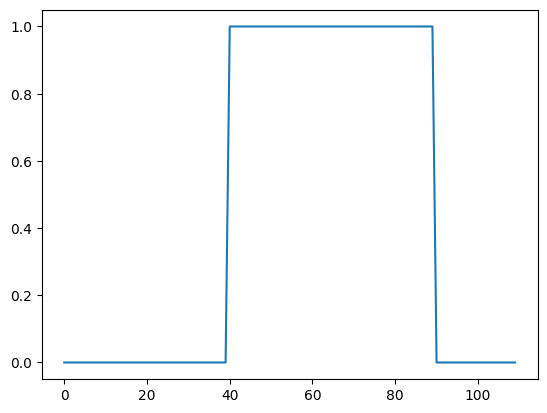

In [171]:
plt.plot(ys[15])